In [1]:
from scripts import Diatom

In [2]:
diatom = Diatom("iLB1027_lipid.xml", "DM")

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2760359
Academic license 2760359 - for non-commercial use only - registered to ma___@ug.uchile.cl


'R_AAL(fum)_c' is not a valid SBML 'SId'.
'R_sink_Asn-X-Ser_Thr_c' is not a valid SBML 'SId'.


## Polytope Sampling

In [3]:
def polytope_pipeline(reactions: tuple[str, str], n_angles: int = 360, delta: float = 0.01, n_clusters: int = 10):
    diatom.set_objective_functions({reactions[1]: 1.0})
    diatom.analyze.project_polytope_2d(reactions, n_angles = n_angles)
    diatom.grid.sample_polytope(delta = delta)
    diatom.grid.debug_plot(delta = delta)
    diatom.analyze.qualitative_analysis(only_load=False)
    diatom.clustering.set_grid_clusters('hierarchical', k = n_clusters)
    diatom.plot.sampled_polytope(show_boundary=True)


def analyze_reactions(reaction_list1: list[str], reaction_list2: list[str], n_angles: int = 720, delta: float = 0.0125) -> None:
    for reaction1 in reaction_list1:
        for reaction2 in reaction_list2:
            polytope_pipeline((reaction1, reaction2), n_angles = n_angles, delta = delta)


Maximize
1.0*DM_biomass_c - 1.0*DM_biomass_c_reverse_c49c1


/home/chuckolate/miniconda3/envs/benpy310_linux/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


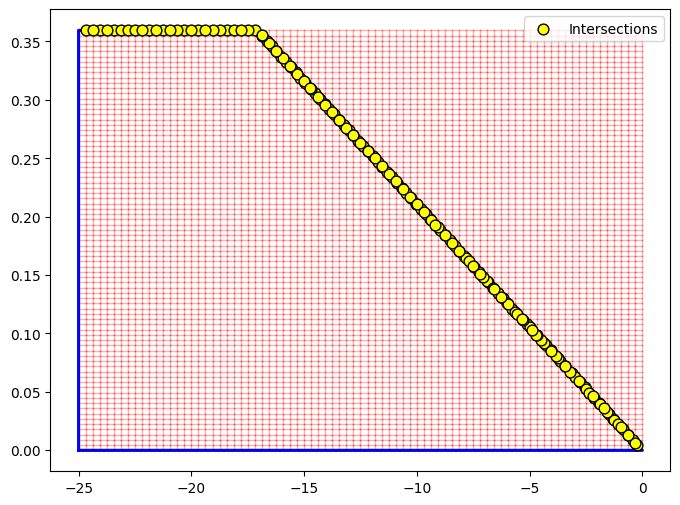

Running qualitative fva over grid feasible points...
No reactions previously selected for FVA and clustering!
Setting reactions for analysis...

Analyzing point feasibility....


100%|██████████| 4467/4467 [00:03<00:00, 1180.60it/s]


Done!

base: (4467, 851) -> one-hot: (4467, 1806)
Clustering grid points ...
Done! n_clusters: 10


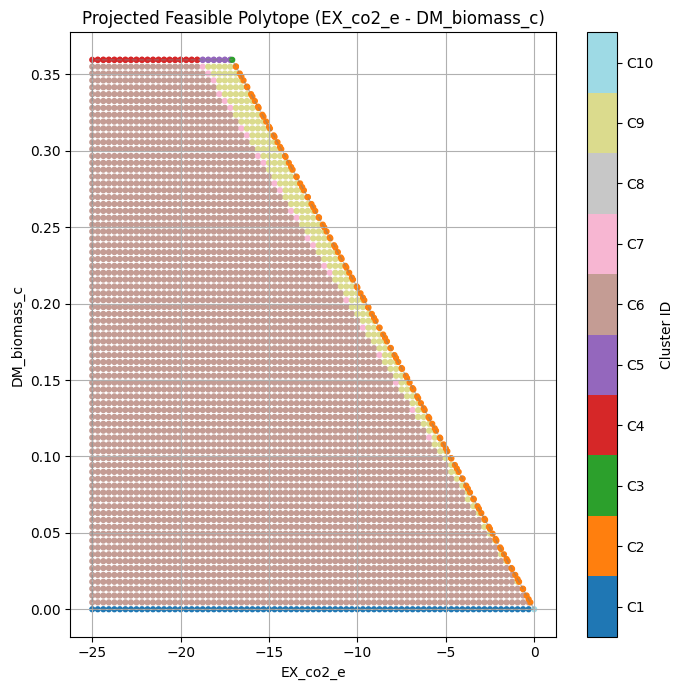

In [4]:
diatom.modify_bounds({"EX_co2_e": (-25, 0)})

reactions1 = ["EX_co2_e"]
#reactions1 = ["EX_no3_e"]
#reactions1 = ["EX_photon_e"]

#reactions2 = ["RUBISO_h"]
#reactions2 = ["RUBISC_h"]
reactions2 = ["DM_biomass_c"]

#diatom.modify_bounds({"EX_photon_e": (-350, 0)})

analyze_reactions(reactions1, reactions2)


## Cluster Analysis

In [5]:
def clustering_pipeline(reaction_list, threshold=0.8, changing=False, overwrite=False):
    print("Qualitative Profiles "+"="*80+"\n")
    qualitative_profiles = diatom.clustering.get_grid_cluster_qual_profiles(threshold=threshold, changing=changing, selected_reactions=reaction_list, overwrite=overwrite)
    display(qualitative_profiles)

    print("Per Reaction Metrics "+"="*80+"\n")
    metrics_per_reaction = diatom.clustering.get_cluster_metrics_per_reaction(reaction_list, overwrite=overwrite)
    display(metrics_per_reaction)

    print("Global Metrics "+"="*80+"\n")
    global_metrics = diatom.clustering.get_cluster_global_metrics(reaction_list, overwrite=overwrite)
    display(global_metrics)

    diatom.io.merge_to_excel({"qualitative profiles": qualitative_profiles, "per reaction metrics": metrics_per_reaction, "global metrics": global_metrics})


In [6]:
df, reaction_list = diatom.clustering.reaction_scores(sort_score = True, sort_index = 5, show = True)

                    votes   mean_rank
MTOBTA_c                6   14.000000
EX_h_e                  5    9.333333
PRAIC_c                 5   29.333333
PRFGCL_c                5   29.916667
PRDPAR_c                5   30.000000
NASO4t_e                5  649.666667
ANTHt_h                 4   27.166667
IGPS_c                  4   28.500000
CHRL_h                  4   30.000000
NITR_c                  4   31.666667
PETHDMT_c               4   32.250000
AIAL_c                  4   34.833333
EX_so4_e                4   35.166667
MAT_c                   4   36.000000
PETHMT_c                4   38.750000
SO3R_h                  4   43.166667
ANPRT_c                 4   45.000000
PRFGS_c                 4   47.583333
PRAIS_c                 4   51.500000
FPGFT_c                 4   52.333333
AMETt_h                 4   94.500000
DXPS_h                  4  115.833333
PRAI_c                  4  375.833333
PPRGL_c                 4  384.500000
PETHTMT_c               4  384.583333
PINAt_e     

In [7]:
REACTIONS = [
    # BIOMASS
    "DM_biomass_c",
    
    # EXCHANGE
    "EX_co2_e",
    "EX_o2_e",
    "EX_h2o_e",
    "EX_co_e", 
    "EX_no3_e",
    "EX_photon_e",
    
    # CHLOROPLAST
    "ATPS_h",
    "ATPM_h",
    "GLNA_h",
    "GLTS_h",
    "ACCOAC_h",
    "ACOATA_h",
    "NTRIR_h",
    "PSII_u",
    "FNOR_h",
    "GDR_NADP_h",
    "RUBISO_h",
    "RUBISC_h", 
    "DXPS_h",
    #"MEHLER_h",

    # MITOCHONDRIA
    "ATPS_m",
    "ATPM_m",
    "GLNA_m",
    "GLTS_m",
    "THD2_m",
    "GLUDH2_m",
    #"AGAS_m",

    # CYTOSOL
    "ATPS_c",
    "TAGAH_HDE_ARA_ARA_c",
    "ACOADAGAT_EPA_EPA_EPA_c",
    "ACOADAGAT_HDE_ARA_ARA_c",
    "NOR_c",
    "PAPA_EPA_EPA_c",
    "NITR_c",
    "HISD_c",
]

clustering_pipeline(reaction_list, overwrite=True)

Qualitative Profiles ================================================================================

cluster_dfs len: 10


,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10
MTOBTA_c,-0,+,+,-+,-+,-+,-+,++,-+,0
EX_h_e,-+,-,-,-+,--,-+,--,--,--,0
PRAIC_c,-0,-,-,-,-,--,--,--,--,0
PRFGCL_c,0+,+,+,+,+,++,++,++,++,0
PRDPAR_c,0+,+,+,+,+,++,++,++,++,0
NASO4t_e,-+,--,--,-+,--,-+,-+,--,--,-0
ANTHt_h,-0,-,-,-,-,--,--,--,--,0
IGPS_c,0+,+,+,+,+,++,++,++,++,0
CHRL_h,0+,+,+,+,+,++,++,++,++,0
NITR_c,0+,+,+,+,+,++,++,++,++,0


Per Reaction Metrics ================================================================================



,reaction_id,cluster,metric,value
0,MTOBTA_c,1,minimum,-5.000000
1,MTOBTA_c,1,maximum,0.000000
2,MTOBTA_c,1,mean_range,2.531250
3,MTOBTA_c,1,mean_midpoint,-1.265625
4,MTOBTA_c,1,mean_relative_range,1.000000
...,...,...,...,...
5735,DM_no3_c,10,frac_zero_fixed,0.000000
5736,DM_no3_c,10,frac_bidirectional,0.000000
5737,DM_no3_c,10,mean_abs_flux,1.760000
5738,DM_no3_c,10,std_range,0.000000


Global Metrics ================================================================================



,cluster,metric,value
0,1,no3_to_co2_capacity_ratio,1.000000
1,1,no3_per_N_biomass_ratio,1.000000
2,1,no3_per_N_biomass_sum,0.880000
3,1,co2_per_C_biomass_ratio,1.000000
4,1,co2_per_C_biomass_sum,12.656250
...,...,...,...
145,10,no3_per_rubisc_difference_ratio,-0.994023
146,10,co2_per_rubisc_difference_ratio,-1.000000
147,10,mean_range_all_reactions,309.541242
148,10,std_range_all_reactions,318.983977


In [8]:
"""
grid_x = [-50, -100, -150, -175]
grid_y = [0.3, 0.2, 0.1]

reaction_couplings = [
    ('EX_co2_e', 'RUBISC_h'),
    ('EX_o2_e', 'RUBISO_h'),
    ("RUBISC_h", "RUBISO_h"),
    ("EX_no3_e", "NTRIR_h")
]

for coupling in reaction_couplings:
    diatom.analyze.quan_FCA(grid_x, grid_y, coupling)
    diatom.plot.plot_qFCA()
"""

'\ngrid_x = [-50, -100, -150, -175]\ngrid_y = [0.3, 0.2, 0.1]\n\nreaction_couplings = [\n    (\'EX_co2_e\', \'RUBISC_h\'),\n    (\'EX_o2_e\', \'RUBISO_h\'),\n    ("RUBISC_h", "RUBISO_h"),\n    ("EX_no3_e", "NTRIR_h")\n]\n\nfor coupling in reaction_couplings:\n    diatom.analyze.quan_FCA(grid_x, grid_y, coupling)\n    diatom.plot.plot_qFCA()\n'